In [71]:
import h5py
from utils import Calibration, draw_path, FULL_FRAME_SIZE
from train.dataloader import load_transformed_video
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os

In [35]:
plot_img_height, plot_img_width = 480, 640 # can be reduced for wandb

fill_color_gt = [0,  255, 0]
line_color_gt = [255,255, 0]
fill_color_preds = [0,  0,255]
line_color_preds = [200,0,255]

laneline_colors = [(255,0,0),(0,255,0),(255,0,255),(0,255,255)]
roadedge_colors = [[255,128,0],[255,128,0]]
X_IDXS = [
         0.    ,   0.1875,   0.75  ,   1.6875,   3.    ,   4.6875,
         6.75  ,   9.1875,  12.    ,  15.1875,  18.75  ,  22.6875,
        27.    ,  31.6875,  36.75  ,  42.1875,  48.    ,  54.1875,
        60.75  ,  67.6875,  75.    ,  82.6875,  90.75  ,  99.1875,
       108.    , 117.1875, 126.75  , 136.6875, 147.    , 157.6875,
       168.75  , 180.1875, 192.]

rpy_calib_gt = [0.00018335809, 0.034165092, -0.014245722]  # real calibration values during this ride
rpy_calib_pred = np.array(rpy_calib_gt) / 2  # calibration we currently use for pre-processing


def legend_color(color, opacity=0.3):
    return np.append(np.array(color)/255, opacity)

In [101]:
base_dir = '/gpfs/space/projects/Bolt/comma_recordings'
# segment = 'comma2k19/Chunk_8/99c94dc769b5d96e|2018-10-06--10-55-28/13' # weird lanelines, path ok?
# segment = 'realdata/2020-08-28--09-58-39--42' # should filter out non-moving segments
# segment = 'realdata/2021-01-22--07-04-41--121' # Good.
segment = 'comma2k19/Chunk_8/99c94dc769b5d96e|2018-09-25--09-06-17/44'


path_to_segment = os.path.join(base_dir, segment)
obj = h5py.File(os.path.join(path_to_segment, 'gt_hacky.h5'), 'r')

print('plans:', obj['plans'].shape)
print('plans_prob:', obj['plans_prob'].shape)
print('lanelines:', obj['lanelines'].shape)
print('laneline_probs:', obj['laneline_probs'].shape)
print('road_edges:', obj['road_edges'].shape)
print('road_edge_stds:', obj['road_edge_stds'].shape)

plans: (1190, 5, 2, 33, 15)
plans_prob: (1190, 5)
lanelines: (1190, 4, 33, 2)
laneline_probs: (1190, 4)
road_edges: (1190, 2, 33, 2)
road_edge_stds: (1190, 2, 33, 2)


In [102]:
_, rgb_frames = load_transformed_video(path_to_segment)

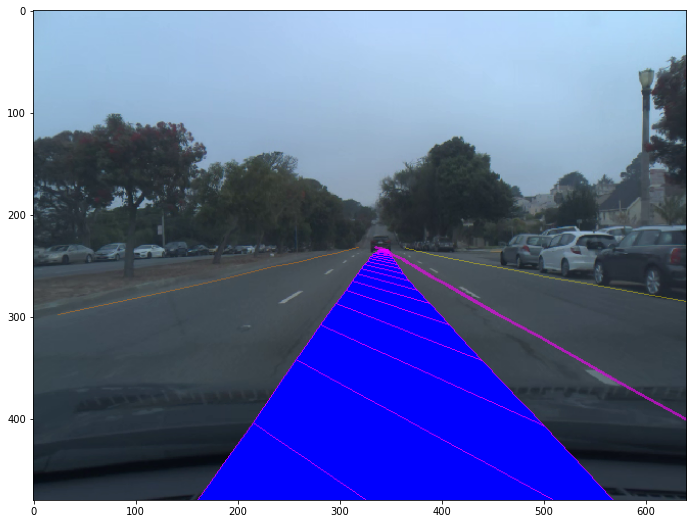

In [111]:
t_idx = 100


# path
best_path_idx = np.argmax(obj['plans_prob'][t_idx, ...])
best_path = obj['plans'][t_idx, best_path_idx, ...] # (2, 33, 15)
path_xyz_pred = best_path[0, :, :3] # (33, 3)

# lanelins & road edges
lanelines = (obj['lanelines'][t_idx, ...], obj['laneline_probs'][t_idx, ...])
road_edges = (obj['road_edges'][t_idx, ...], obj['road_edge_stds'][t_idx, ...])

# frame
rgb_frame = rgb_frames[t_idx]

# rpy_calib_pred = [0, 0.007, 0]  # calibration we currently use for pre-processing
rpy_calib_pred = [0, 0.010, 0.03]  # calibration we currently use for pre-processing


calibration = Calibration(rpy_calib_pred, plot_img_width=plot_img_width, plot_img_height=plot_img_height)

img_plot = draw_path(lanelines, road_edges, path_xyz_pred, rgb_frame, calibration, X_IDXS, laneline_colors, fill_color=fill_color_preds, line_color=line_color_preds)


plot_width = 12
plot_height = plot_width * (FULL_FRAME_SIZE[1] / FULL_FRAME_SIZE[0])
plt.figure(figsize=(plot_width, plot_height))

plt.imshow(img_plot)

plt.show()

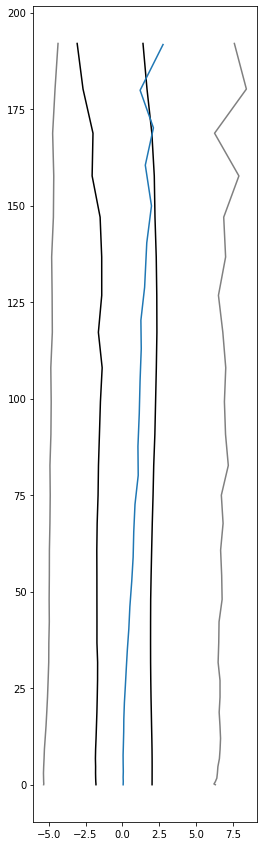

In [104]:
plt.figure(figsize=(4, 15))

plt.plot(lanelines[0][0, :, 0], X_IDXS, color='grey')
plt.plot(lanelines[0][1, :, 0], X_IDXS, color='black')
plt.plot(lanelines[0][2, :, 0], X_IDXS, color='black')
plt.plot(lanelines[0][3, :, 0], X_IDXS, color='grey')

plt.plot(path_xyz_pred[:, 1], path_xyz_pred[:, 0])